In [187]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = 15,10
rcParams['image.cmap'] = 'Greys_r'
%matplotlib inline

In [2]:
def imshow(img):
    plt.imshow(img[:,:,::-1])

In [3]:
im1 = cv2.imread('./task1.png')
im2 = cv2.imread('./task2.jpg')

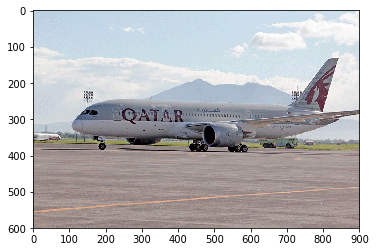

In [4]:
imshow(im1)

### approach 0

In [5]:
def pad(arr):
    if type(arr[0][0]) is list:
        ins = [0,0,0]
    else:
        ins = 0
        
    for row in arr:
        row.insert(0,ins)
        row.append(ins)

    arr.insert(0, [ins for x in arr[0]])
    arr.append([ins for x in arr[0]])

class Kernel():
    def __init__(self, lst):
        self.data = lst
        self.size = len(lst)
        self.middle = self.size // 2
    
    def __getitem__(self,idx):
        return self.data[self.middle - idx[0]][self.middle - idx[1]]
    
    def t(self):
        return Kernel([[k[i] for k in kernel] for i in range(len(kernel))])

def conv0(arr, kernel):
    assert type(arr) is list, "arr should be a list"
    assert type(kernel) is Kernel, "kernel should be of type Kernel"
    kernel_size = kernel.size
    pad_size = kernel_size // 2
    for i in range(pad_size):
        pad(arr)
        
    res = []
    for i in range(pad_size, len(arr) - pad_size):
        res.append([])
        for j in range(pad_size, len(arr[0]) - pad_size):
            c = 0
            for m in range(-pad_size, pad_size + 1):
                for n in range(-pad_size, pad_size + 1):
                    c+= sum(arr[i+m][j+n])*kernel[m,n]
            res[i-pad_size].append(c)
    return res

### approach 1

In [6]:
def conv(arr, kernel):
    padding = tuple(np.floor_divide(kernel.shape,2))
    if len(arr.shape)==3:
        arr_ = arr.sum(axis=2)
    else:
        arr_ = arr
    arr_p = np.pad(arr_, padding, mode='constant', constant_values=0)
    temp = np.lib.stride_tricks.as_strided(arr_p, arr_.shape + kernel.shape, arr_p.strides + arr_p.strides)
    return np.reshape(
        [(x*kernel[::-1,::-1]).sum() for x in temp.reshape(-1,*kernel.shape)], arr_.shape
    )

### approach 2, better using numpy vectorization

In [7]:
def conv2(arr, kernel):
    padding = tuple(np.floor_divide(kernel.shape,2))
    if len(arr.shape)==3:
        arr_ = arr.sum(axis=2)
    else:
        arr_ = arr
    arr_p = np.pad(arr_, padding, mode='constant', constant_values=0)
    temp = np.lib.stride_tricks.as_strided(arr_p, arr_.shape + kernel.shape, arr_p.strides + arr_p.strides)
    
    return np.sum(
        [temp[:,:,i,j]*kernel[2-i,2-j] for i in range(kernel.shape[0]) for j in range(kernel.shape[1])],
        axis=0
    )

### importing scipy implementation for comparison

In [8]:
from scipy.signal import convolve2d

### post_processing

In [9]:
def post_proc(img):
    max_val = max(map(max, img))
    min_val = min(map(min, img))
    img = np.asarray(img)
    res1 = (img - min_val) / (max_val - min_val)
    res2 = abs(img)/max(max_val,-min_val)
    return res1,res2

### speed test

In [10]:
kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
kernel0 = Kernel([[-1,0,1],[-2,0,2],[-1,0,1]])

In [11]:
# %%timeit
# conv0(im1.tolist(), kernel0)

In [12]:
# %%timeit
# conv(im1, kernel)

In [13]:
# %%timeit
# conv2(im1, kernel)

In [14]:
# %%timeit
# convolve2d(im1.sum(axis=2), kernel, mode='same')

### correctness test

In [15]:
# np.all(conv(im1, kernel) == conv2(im1, kernel)) and \
# np.all(conv2(im1,kernel) == convolve2d(im1.sum(axis=2), kernel, mode='same')) and \
# np.all(conv2(im1,kernel) == np.asarray(conv0(im1.tolist(), kernel0)))

### actual sobel filtering

In [16]:
def sobel(img):
    """computes gradient magnitude"""
    kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    Gx = conv2(img, kernel)
    Gy = conv2(img, kernel.T)
    return np.sqrt(Gx**2 + Gy**2)

### results visualization

In [17]:
Gx = post_proc(conv0(im1.tolist(),kernel0))
Gy = post_proc(conv0(im1.tolist(),kernel0.t()))

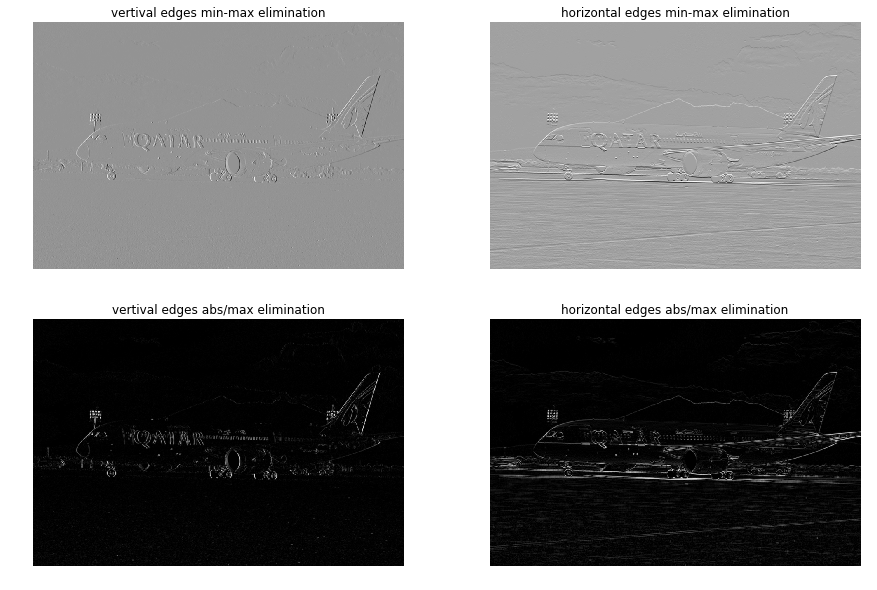

In [18]:
f,ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].imshow(Gx[0], cmap='Greys_r')
ax[0,0].set_title('vertival edges min-max elimination')
ax[0,1].imshow(Gy[0], cmap='Greys_r')
ax[0,1].set_title('horizontal edges min-max elimination')

ax[1,0].imshow(Gx[1], cmap='Greys_r')
ax[1,0].set_title('vertival edges abs/max elimination')
ax[1,1].imshow(Gy[1], cmap='Greys_r')
ax[1,1].set_title('horizontal edges abs/max elimination')

for a in ax.ravel():
    a.axis('off')

---
### Task 2

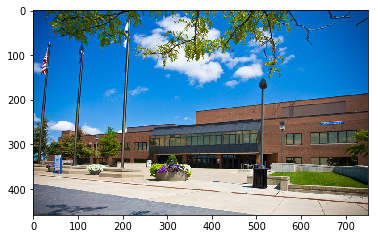

In [25]:
imshow(im2)

In [26]:
def Gauss(sigma):
    def f(x,y):
        return 1/(2*np.pi*4sigma**2)*np.exp(-(x**2+y**2)/(2*sigma**2))
    return f

In [215]:
#octaves
octaves = {
    1: [1/np.sqrt(2), 1, np.sqrt(2), 2, 2*np.sqrt(2)],
    2: [np.sqrt(2), 2, 2*np.sqrt(2), 4, 4*np.sqrt(2)],
    3: [2*np.sqrt(2), 4, 4*np.sqrt(2), 8, 8*np.sqrt(2)],
    4: [4*np.sqrt(2), 8, 8*np.sqrt(2), 16, 16*np.sqrt(2)]
}

In [216]:
f = Gauss(5*np.sqrt(2))

In [217]:
def np_meshgrid(rng):
    X = [list(rng) for x in range(len(rng))]
    Y = [[k[i] for k in X] for i in range(len(X))]
    return np.asarray(X),np.asarray(Y)

In [218]:
X,Y = np_meshgrid(range(-3,4))

In [219]:
kern = f(X,Y)

In [220]:
def normalize(x):
    return x / sum(sum(x))

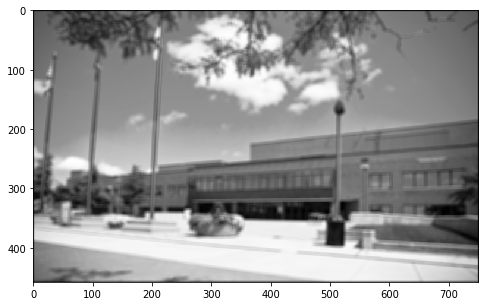

In [221]:
plt.figure(figsize=(15,5))
plt.imshow(
    conv2(im2.mean(axis=2), normalize(f(X,Y))),
    cmap='Greys_r'
)

In [222]:
# oct_images = {
#     k: [conv2(im2.mean(axis=2), normalize( Gauss(v_p)(X,Y)) ) for v_p in v] for k,v in octaves.items()
# }

In [223]:
oct_images = {
    k: [cv2.GaussianBlur(im2.mean(axis=2), (7,7), v_p) for v_p in v] for k,v in octaves.items()
}

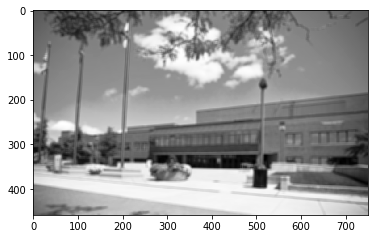

In [224]:
plt.imshow(
    oct_images[3][3], cmap='Greys_r'
)

In [225]:
def DoG(oct_images):
    return {
        k: [im1-im0 for im0,im1 in zip(ar[:-1],ar[1:])] for k, ar in oct_images.items()
    }

In [226]:
dogs = DoG(oct_images)

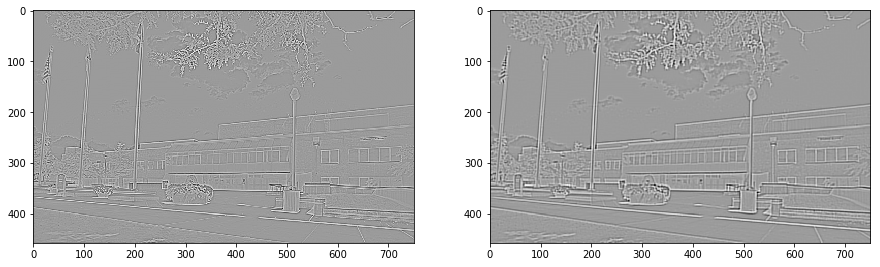

In [227]:
f,ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(
    dogs[1][0], cmap='Greys_r'
)
ax[1].imshow(
	dogs[1][3], cmap='Greys_r'
)

In [228]:
dogs1 = np.r_[dogs[3][:3]]

In [229]:
from operator import le, ge

def check(dogs, operator=ge):
    tmp = np.ones_like(dogs[1,1:-1,1:-1], dtype='uint8')
    s = np.s_[:-2],np.s_[1:-1],np.s_[2:]
    for d in range(3):
        for s_i in s:
            for s_j in s:
                tmp = tmp & operator(dogs[1,1:-1,1:-1], dogs[d,s_i,s_j])
    return tmp

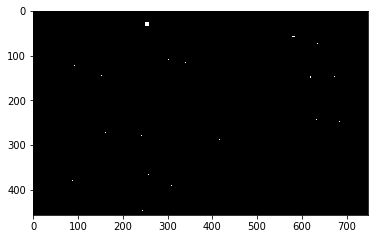

In [233]:
plt.imshow(
    check(dogs1, ge)
)

In [43]:
def extreme_point(i,j,d_idx,dogs):
    center = dogs[d_idx][i,j]
    for f in min,max:
        extreme = f(
                f(f(dogs[d_idx-1][i-1:i+2, j-1:j+2].tolist())),
                f(f(dogs[d_idx][i-1:i+2, j-1:j+2].tolist())),
                f(f(dogs[d_idx+1][i-1:i+2, j-1:j+2].tolist()))
            )
        if extreme == center:
            return 1
    return 0

In [44]:
h,w = dogs[1][0].shape

In [45]:
d_idx = 2
res = [[]]
for i in range(1,h): #-1
    for j in range(1,w): #-1
        res[i-1].append(extreme_point(i, j, d_idx, dogs[1]))
    res.append([])
res.pop()

[]

(-0.5, 748.5, 456.5, -0.5)

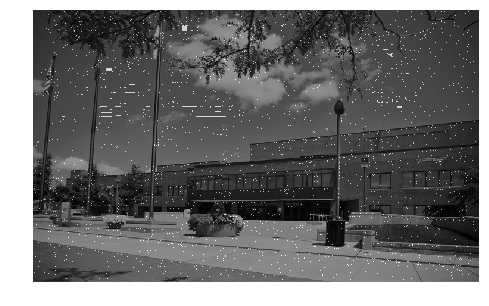

In [46]:
plt.figure(figsize=(15,5))
plt.imshow(
    im2.mean(axis=2)[1:,1:] + np.asarray(res)*255, cmap='Greys_r'
)
plt.axis('off')

### Task3

In [243]:
import cv2
from collections import Counter
from tqdm import tqdm_notebook as tqdm
from matplotlib.patches import Rectangle

In [244]:
img_names = !ls ./task3 | grep jpg | grep -v template

In [245]:
imgs = [cv2.cvtColor(cv2.imread('./task3/'+i),cv2.COLOR_BGR2HSV) for i in img_names]

In [246]:
def match_template(image, template, mask):
    """performs masked correlation matching"""
    shape = tuple(np.subtract(image.shape,template.shape))
    im_r = np.lib.stride_tricks.as_strided(image, shape+template.shape, image.strides + image.strides)
    ccor = (
        (im_r - im_r.mean(axis=(2,3))[:,:,np.newaxis,np.newaxis]) * (template - template.mean())[np.newaxis,np.newaxis,:,:] * mask[np.newaxis,np.newaxis,:,:]
    ).sum(axis=(2,3))
    ccor[ccor < 0] = 0
    ccor = ccor / ccor.max()
    res = cv2.minMaxLoc(ccor)
    return res[1], res[3]

def match_template2(image, template, mask):
    """normalizes image batch-wise and performs masked correlation matching"""
    shape = tuple(np.subtract(image.shape,template.shape))
    im_r = np.lib.stride_tricks.as_strided(image, shape+template.shape, image.strides + image.strides) * mask[np.newaxis, np.newaxis,:,:]
    
    im_r = im_r - im_r.min(axis=(2,3))[:,:,np.newaxis,np.newaxis]
    im_r = im_r / (im_r.max(axis=(2,3)) + 0.1)[:,:,np.newaxis,np.newaxis]
    
    template = template - template.min()
    template = template / template.max() + 0.1
    
    ccor = (
        (im_r - im_r.mean(axis=(2,3))[:,:,np.newaxis,np.newaxis]) * (template - template.mean())[np.newaxis,np.newaxis,:,:] * mask[np.newaxis,np.newaxis,:,:]
    ).sum(axis=(2,3))
    ccor[ccor < 0] = 0
    ccor_max = ccor.max()
    ccor = ccor / ccor_max
    return ccor_max, cv2.minMaxLoc(ccor)[3]

helper = lambda im, mask, scale: (cv2.resize(im, None, fx=scale, fy=scale), cv2.resize(mask, None, fx=scale, fy=scale))

def find_cursor(image, template, mask):
    scale_range = np.linspace(0.8,1.1,num=8)
    matches = [match_template2(image,*helper(template, mask, scale)) for scale in tqdm(scale_range)]
    confidence = [x[0] / s**2 for x,s in zip(matches, scale_range)]
    loc = [x[1] for x in matches]
    mode = Counter(loc).most_common()
    return mode[0], (confidence, loc)

### DoG approach

In [551]:
canny_t = cv2.Canny(templ_orig, 10, 100)

In [686]:
def doggo(im_v):
    return cv2.GaussianBlur(im_v, (5,5), 8*np.sqrt(2)).astype('float32') - cv2.GaussianBlur(im_v, (5,5), 3*np.sqrt(2))

def find_candidates(img, sc_temps):
    dog = doggo(img)
    locs = [cv2.minMaxLoc(
                cv2.matchTemplate(dog, tmp, cv2.TM_CCORR_NORMED)
            )[3] for tmp in sc_temps]
    shapes = [s.shape for s in sc_temps]
    matches = [
        cv2.resize(
            img[l[1]:l[1]+s[0],l[0]:l[0]+s[1]], (10,15)
        ) for l,s in zip(locs, shapes)
    ]
    
    std = [(l,m.std()) for l,m in zip(locs, matches)]
    
    return locs, matches

def find_best_one(template, locs, matches):
    sobel11 = cv2.Sobel(template, 2, 1, 1)
    sobel10 = cv2.Sobel(template, 2, 1, 0)
    canny_t = cv2.Canny(template, 10, 100)
    canny_t[0,:] = 0 #masking background
    canny_t[:,0] = 0
    
    s_score_func = lambda x: (
        cv2.Sobel(x,2,1,0) & sobel10
    ).sum() * 0.5 + (
        cv2.Sobel(x,2,1,1) & sobel11
    ).sum() * 0.5
    
    c_score_func = lambda x: (cv2.Canny(x, 10, 100) & canny_t).sum()
    
    s_scores = [s_score_func(x) for x in matches]
    c_scores = [c_score_func(x) for x in matches]
    
    scores = [ss*0.6+cs*0.4 for ss,cs in zip(s_scores, c_scores)]
    best = np.argmax(scores)
    
    return locs[best], matches[best], scores[best] if scores[best] > 4500 else None

dog = doggo(imgs[10][:,:,2])

template = dog[273:288,865:875]
templ_orig = imgs[10][273:288,865:875,2]
sc_temps = [cv2.resize(template,None, fx=s, fy=s) for s in np.linspace(0.7, 1.1, 16)]

In [687]:
def plot(image, locs, loc_top=None):
    f,ax = plt.subplots(1,1,figsize=(20,10))
    ax.imshow(image, cmap='Greys_r')
    for loc in locs:
        ax.add_patch(
            Rectangle((loc[0],loc[1]),10,15,linewidth=1,edgecolor='b',facecolor='none')
        )

    if loc_top:
        ax.add_patch(
            Rectangle((loc_top[0],loc_top[1]),10,15,linewidth=3,edgecolor='r',facecolor='none')
        )
    return f,ax